In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-covid-sa-fake-sentiment/data-covid-sa-fake-sentiment.xlsx
/kaggle/input/data-covid-sa-fake-sentiment/Stopwords.txt


In [2]:
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install transformers openpyxl tqdm datasets scikit-learn gradio torch accelerate -q

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-odp_1ia8
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-odp_1ia8
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=796ca900d25823769e484444de38c7decf06d4e40d00f5777d9c0f0d33a2fc79
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzha1oid/wheels/9a/af/fc/4c056274507dc80328a36c6ee1b71d78d6473edb0c1f5edc3e
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=e602a89e3c598c4074530035c5185808f633a8bb

In [3]:
import math, json, re, random, time, gc
from dataclasses import dataclass
from typing import List, Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import transformers
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup, AutoConfig, PreTrainedModel, PretrainedConfig

from normalizer import normalize
from multiprocessing import Pool, cpu_count
import shutil
import warnings
warnings.filterwarnings('ignore')

2025-09-18 17:36:52.810193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758217013.035929      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758217013.102829      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
torch.backends.cudnn.benchmark = True  # Faster convolutions for fixed input sizes
torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 for matmul (faster)
torch.backends.cudnn.allow_tf32 = True  # Allow TF32 for convolutions

In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
# ----- Paths -----
EXCEL_PATH = "/kaggle/input/data-covid-sa-fake-sentiment/data-covid-sa-fake-sentiment.xlsx"  # change if needed
SAVE_DIR   = "/kaggle/working/banglabert_multitask"
os.makedirs(SAVE_DIR, exist_ok=True)

In [7]:
# ----- Hyperparameters -----
MODEL_NAME = "csebuetnlp/banglabert"
MAX_LENGTH = 512
BATCH_SIZE = 16
GRAD_ACCUM_STEPS = 4
EPOCHS = 15
FIXED_LR = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
ALPHA_SENTIMENT = 0.90
DEBUG_MODE = False

USE_GRAD_CHECKPOINT = False

In [8]:
SENTIMENT_MAP = {"negative":0, "neutral":1, "positive":2}
TRUTH_MAP     = {"fake":0, "real":1}

In [9]:
# Reverse maps for decoding
idx2sent = {v: k for k, v in SENTIMENT_MAP.items()}
idx2truth = {v: k for k, v in TRUTH_MAP.items()}

In [10]:
df = pd.read_excel(EXCEL_PATH)

In [11]:
# keep first occurrence of exact duplicates (text + both labels identical)
df = df.drop_duplicates(subset=["text", "sentiment", "truthfulness"], keep="first")

In [12]:
# --- 1. Basic Overview ---
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSample rows:\n", df.head())

Dataset shape: (35526, 3)

Column names: ['text', 'sentiment', 'truthfulness']

Data types:
 text            object
sentiment       object
truthfulness    object
dtype: object

Missing values:
 text            0
sentiment       0
truthfulness    0
dtype: int64

Sample rows:
                                                 text sentiment truthfulness
0  করোনা বিষয়ে চারটি পৃথক কমিটি করেছে স্বাস্থ্য অ...   Neutral         real
1  চট্টগ্রামে করোনাভাইরাসে আক্রান্ত আরও একজনের মৃ...  Negative         real
2  যশোরে করোনাভাইরাসে আক্রান্ত হয়ে এক দিনে দুজনের...  Negative         real
3  রাজশাহীতে আজ রোববার ৩১ জনের নমুনা পরীক্ষায় ৯ জ...  Negative         real
4  চট্টগ্রামে নতুন করে ৯ জনের করোনা শনাক্ত হয়েছে।...  Negative         real


In [13]:
df['sentiment'].value_counts()

sentiment
Negative    15453
Positive    14939
Neutral      5134
Name: count, dtype: int64

In [14]:
df['truthfulness'].value_counts()

truthfulness
real    25940
fake     9586
Name: count, dtype: int64

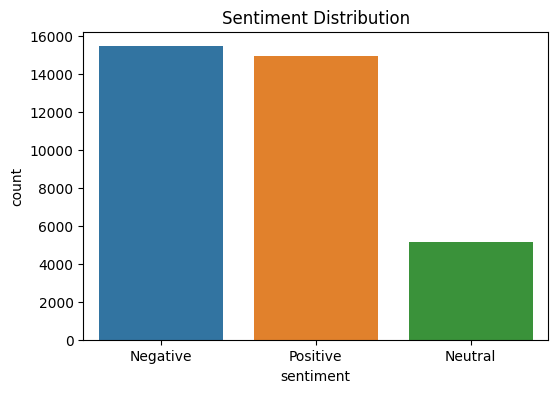

In [15]:
# --- 2. Sentiment Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title("Sentiment Distribution")
plt.show()

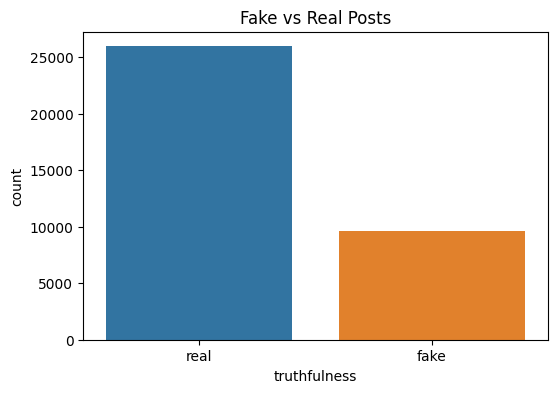

In [16]:
# --- 3. Fake vs Real Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='truthfulness', data=df)
plt.title("Fake vs Real Posts")
plt.show()

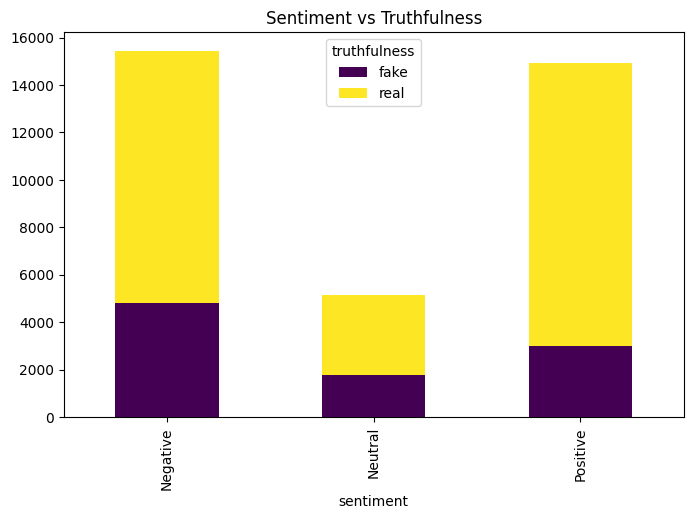

In [17]:
# Crosstab of Fake/Real vs Sentiment
cross_tab = pd.crosstab(df['sentiment'], df['truthfulness'])
cross_tab.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')
plt.title("Sentiment vs Truthfulness")
plt.show()

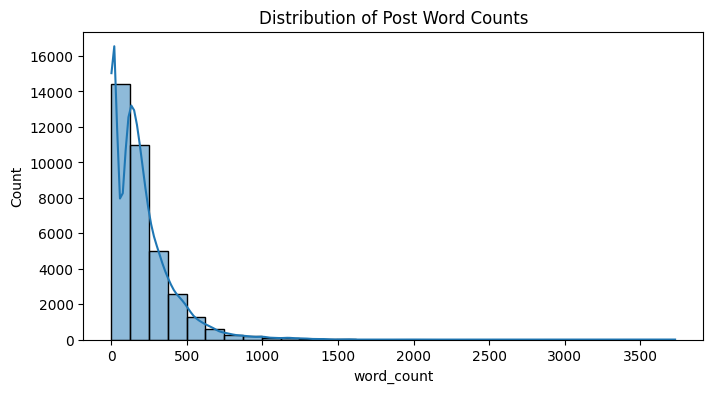

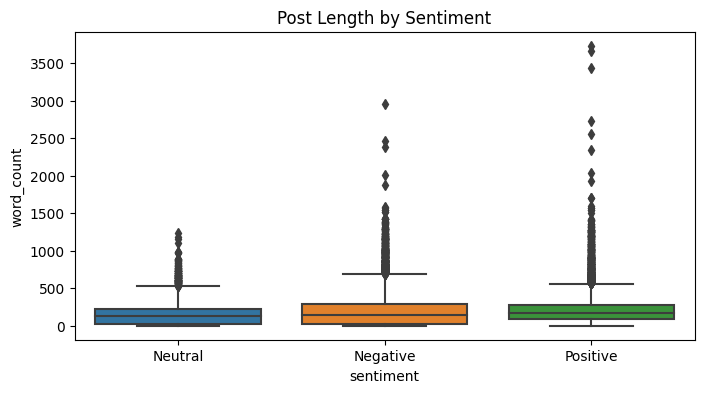

In [18]:
# --- 4. Text Length Analysis ---
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Distribution of Post Word Counts")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title("Post Length by Sentiment")
plt.show()

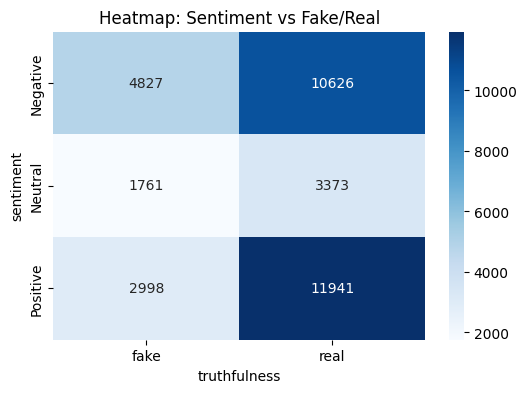

In [19]:
# --- 7. Heatmap: Sentiment vs Fake/Real ---
plt.figure(figsize=(6,4))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap: Sentiment vs Fake/Real")
plt.show()

In [20]:
# 1️⃣ Compile the “whitespace‑collapse” regex once (global)
_COLLAPSE_RE = re.compile(r"\s+")

def _clean_one(text: str) -> str:
    """
    Normalise a **single** string, then collapse whitespace and strip.
    This function is deliberately tiny – it will be executed in a separate
    process, so we want to avoid any heavy imports inside it.
    """
    txt = normalize(
        text,
        unicode_norm="NFKC",
        punct_replacement=None,
        url_replacement="",
        emoji_replacement="",
        apply_unicode_norm_last=True,
    )
    # Collapse any run of whitespace into a single space
    txt = _COLLAPSE_RE.sub(" ", txt).strip()
    return txt

In [21]:
def _batch_normalize(texts):
    """
    Wrapper that receives a *list* of strings (one chunk) and returns the
    cleaned list.  It is executed in a worker process.
    """
    return [_clean_one(t) for t in texts]

In [22]:
def parallel_preprocess(text_series, n_jobs: int = None, chunk_size: int = 2000):
    """
    Fast multi-process preprocessing.
    """
    if n_jobs is None:
        n_jobs = min(max(1, cpu_count() // 2), 8)

    # Convert to a plain list of strings (ensures no NaNs)
    raw_texts = text_series.astype(str).tolist()

    total = len(raw_texts)
    if total == 0:
        return pd.Series([], dtype=str)

    # Calculate optimal chunk size if not supplied
    if chunk_size is None:
        chunk_size = max(1, total // (n_jobs * 4))

    # Build list of slices
    chunks = [raw_texts[i : i + chunk_size] for i in range(0, total, chunk_size)]

    print(f"🔧 Pre-processing {total:,} rows with {n_jobs} process(es) (chunk size ≈ {chunk_size}) …")

    # Now it's safe to compare: n_jobs is an int
    if n_jobs > 1:
        with Pool(processes=n_jobs) as pool:
            cleaned_chunks = list(pool.imap_unordered(_batch_normalize, chunks, chunksize=1))
    else:
        # Single process: avoid Pool overhead
        cleaned_chunks = [_batch_normalize(chunk) for chunk in chunks]

    # Flatten the list of chunks back into one list and wrap as Series
    cleaned_texts = [txt for chunk in cleaned_chunks for txt in chunk]

    # Verify length sanity
    assert len(cleaned_texts) == total, (
        f"Length mismatch after cleaning: expected {total}, got {len(cleaned_texts)}"
    )

    return pd.Series(cleaned_texts, index=text_series.index)

In [23]:
# Load custom stop words from a file
def load_custom_stop_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words = set(file.read().splitlines())
    return stop_words

stop_words_file_path = '/kaggle/input/data-covid-sa-fake-sentiment/Stopwords.txt'
custom_stop_words = load_custom_stop_words(stop_words_file_path)

In [24]:
def stopwords_removal(text):
    text = ' '.join([word for word in text.split() if word.lower() not in custom_stop_words])
    return text

In [25]:
df["text"] = parallel_preprocess(df["text"])
df['text'] = df['text'].astype(str).apply(stopwords_removal)
df = df[df['text'].str.strip() != ""]

🔧 Pre-processing 35,526 rows with 2 process(es) (chunk size ≈ 2000) …


In [26]:
SENTIMENT_ALIASES = {
    "pos":"positive", "positive":"positive",
    "neg":"negative", "negative":"negative",
    "neu":"neutral",  "neutral":"neutral",
    "Positive":"positive", "Neutral":"neutral", "Negative":"negative"
}
TRUTH_ALIASES = {
    "fake":"fake","fake news":"fake","false":"fake",
    "real":"real","true":"real","true news":"real"
}

In [27]:
def encode_series(series, label_map, aliases, colname):
    """
    Label encoding with alias normalization.
    - Lowercases + strips values
    - Replaces using alias dictionary
    - Validates against label_map
    """
    # Clean text
    cleaned = series.astype(str).str.strip().str.lower()

    # Apply alias mapping
    cleaned = cleaned.replace(aliases)

    # Validate
    bad_mask = ~cleaned.isin(label_map.keys())
    if bad_mask.any():
        bad_examples = series[bad_mask].unique()
        raise ValueError(
            f"❌ Unmapped labels in '{colname}': {bad_examples}. "
            f"Expected one of {list(label_map.keys())}"
        )

    # Map to integers
    return cleaned.map(label_map).to_numpy(dtype=np.int64)

y_s = encode_series(df["sentiment"], SENTIMENT_MAP, SENTIMENT_ALIASES, "sentiment")
y_t = encode_series(df["truthfulness"], TRUTH_MAP, TRUTH_ALIASES, "truthfulness")

In [28]:
# Train/val/test split
df_train, df_temp, y_s_train, y_s_temp, y_t_train, y_t_temp = train_test_split(
    df, y_s, y_t,
    test_size=0.2,
    random_state=SEED,
    stratify=y_s
)
df_val, df_test, y_s_val, y_s_test, y_t_val, y_t_test = train_test_split(
    df_temp, y_s_temp, y_t_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_s_temp
)

print("Train:", df_train.shape, "Val:", df_val.shape, "Test:", df_test.shape)

Train: (28420, 5) Val: (3553, 5) Test: (3553, 5)


In [29]:
# Double-check directory exists before saving
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR, exist_ok=True)
    print(f"Created directory: {SAVE_DIR}")

# Save label maps
with open(os.path.join(SAVE_DIR, "sentiment_map.json"), "w", encoding="utf-8") as f:
    json.dump(SENTIMENT_MAP, f, ensure_ascii=False, indent=2)
with open(os.path.join(SAVE_DIR, "truth_map.json"), "w", encoding="utf-8") as f:
    json.dump(TRUTH_MAP, f, ensure_ascii=False, indent=2)

In [30]:
counts_t = np.bincount(y_t_train, minlength=2)
freqs_t = counts_t / counts_t.sum()
inv_t = 1.0 / np.clip(freqs_t, 1e-8, None)
truth_class_weights = torch.tensor(inv_t / inv_t.mean(), dtype=torch.float32, device=DEVICE)

In [31]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [32]:
def tokenize_dataset(df, tokenizer, max_length=MAX_LENGTH, batch_size=256):
    texts = df["text"].astype(str).tolist()
    all_input_ids, all_attention_mask = [], []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
        batch = texts[i:i + batch_size]
        encoded = tokenizer(batch, padding="max_length", truncation=True, 
                           max_length=max_length, return_tensors="pt")
        all_input_ids.append(encoded["input_ids"])
        all_attention_mask.append(encoded["attention_mask"])
    
    return {
        "input_ids": torch.cat(all_input_ids, dim=0),
        "attention_mask": torch.cat(all_attention_mask, dim=0)
    }

In [33]:
# Caching
CACHE_DIR = os.path.join(SAVE_DIR, "tokenized_data")
os.makedirs(CACHE_DIR, exist_ok=True)

def load_or_tokenize(df, tokenizer, split_name):
    cache_path = os.path.join(CACHE_DIR, f"{split_name}_encodings.pt")
    if os.path.exists(cache_path):
        print(f"🔁 Loading cached {split_name}...")
        return torch.load(cache_path)
    print(f"📝 Tokenizing {split_name}...")
    encodings = tokenize_dataset(df, tokenizer, MAX_LENGTH)
    torch.save(encodings, cache_path)
    return encodings

In [34]:
# PreTokenizedDataset that stores the original dataframe indices
class PreTokenizedDataset(Dataset):
    def __init__(self, encodings, y_s, y_t, orig_idx):
        """
        encodings: dict of tensors 'input_ids','attention_mask' (shape N x L)
        y_s, y_t: numpy arrays or lists (length N)
        orig_idx: list/array of original row indices from the dataframe (length N)
        """
        self.input_ids = encodings["input_ids"]
        self.attention_mask = encodings["attention_mask"]
        self.y_s = torch.tensor(y_s, dtype=torch.long)
        self.y_t = torch.tensor(y_t, dtype=torch.long)
        self.orig_idx = torch.tensor(orig_idx, dtype=torch.long)

        # Sanity check
        n = self.input_ids.shape[0]
        assert self.attention_mask.shape[0] == n
        assert len(self.y_s) == n
        assert len(self.orig_idx) == n

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        # return orig_idx as Python int (or tensor) as well
        return self.input_ids[idx], self.attention_mask[idx], self.y_s[idx], self.y_t[idx], int(self.orig_idx[idx])

# Collator that preserves indices
@dataclass
class Collator:
    def __call__(self, batch):
        # batch is list of tuples: (input_ids, attention_mask, y_s, y_t, orig_idx)
        input_ids, attention_mask, ys, yt, idxs = zip(*batch)
        return (torch.stack(input_ids),
                torch.stack(attention_mask),
                torch.tensor(ys, dtype=torch.long),
                torch.tensor(yt, dtype=torch.long),
                torch.tensor(idxs, dtype=torch.long))

In [35]:
train_encodings = load_or_tokenize(df_train, tokenizer, "train")
val_encodings = load_or_tokenize(df_val, tokenizer, "val")
test_encodings = load_or_tokenize(df_test, tokenizer, "test")

train_idx = df_train.index.tolist()
val_idx   = df_val.index.tolist()
test_idx  = df_test.index.tolist()

train_ds = PreTokenizedDataset(train_encodings, y_s_train, y_t_train, train_idx)
val_ds   = PreTokenizedDataset(val_encodings,   y_s_val,   y_t_val,   val_idx)
test_ds  = PreTokenizedDataset(test_encodings,  y_s_test,  y_t_test,  test_idx)

📝 Tokenizing train...


Tokenizing: 100%|██████████| 112/112 [00:34<00:00,  3.28it/s]


📝 Tokenizing val...


Tokenizing: 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


📝 Tokenizing test...


Tokenizing: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]


In [36]:
collate_fn = Collator()

In [37]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)

In [38]:
print("=" * 80)
print("🔍 DATASET LABEL SANITY CHECK - RUN BEFORE EVERY EXPERIMENT")
print("=" * 80)

def check_label_consistency(series, label_map, aliases, col_name, split_name):
    """
    Check alignment between raw labels, normalized labels, and the target map.
    Returns a DataFrame with samples for manual inspection.
    """
    print(f"\n--- {split_name} Set: '{col_name}' ---")

    # Step 1: Get unique raw labels
    raw_labels = series.astype(str).str.strip().unique()
    print(f"  Unique RAW labels ({len(raw_labels)}): {sorted(raw_labels)}")

    # Step 2: Apply alias normalization
    cleaned = series.astype(str).str.strip().str.lower()
    cleaned = cleaned.replace(aliases)
    normalized_labels = cleaned.unique()
    print(f"  After ALIAS normalization ({len(normalized_labels)}): {sorted(normalized_labels)}")

    # Step 3: Check against final label map
    unmapped = [lbl for lbl in normalized_labels if lbl not in label_map]
    if unmapped:
        print(f"  ❌ CRITICAL: Unmapped labels found: {unmapped}")
    else:
        print(f"  ✅ All normalized labels map to target IDs.")

    # Step 4: Show a sample mapping for clarity
    sample_df = pd.DataFrame({
        'raw_label': series.astype(str).str.strip().head(5).tolist(),
        'normalized': cleaned.head(5).tolist(),
        'mapped_id': cleaned.head(5).map(label_map).tolist()
    })
    print(f"  Sample mapping (first 5 rows):")
    print(sample_df.to_string(index=False))

    return unmapped

# --- Run checks for Sentiment ---
print("\n" + "="*40)
print("SENTIMENT LABELS")
print("="*40)

sent_train_unmapped = check_label_consistency(df_train["sentiment"], SENTIMENT_MAP, SENTIMENT_ALIASES, "sentiment", "TRAIN")
sent_val_unmapped = check_label_consistency(df_val["sentiment"], SENTIMENT_MAP, SENTIMENT_ALIASES, "sentiment", "VAL")
sent_test_unmapped = check_label_consistency(df_test["sentiment"], SENTIMENT_MAP, SENTIMENT_ALIASES, "sentiment", "TEST")

# --- Run checks for Truthfulness ---
print("\n" + "="*40)
print("TRUTHFULNESS LABELS")
print("="*40)

truth_train_unmapped = check_label_consistency(df_train["truthfulness"], TRUTH_MAP, TRUTH_ALIASES, "truthfulness", "TRAIN")
truth_val_unmapped = check_label_consistency(df_val["truthfulness"], TRUTH_MAP, TRUTH_ALIASES, "truthfulness", "VAL")
truth_test_unmapped = check_label_consistency(df_test["truthfulness"], TRUTH_MAP, TRUTH_ALIASES, "truthfulness", "TEST")

🔍 DATASET LABEL SANITY CHECK - RUN BEFORE EVERY EXPERIMENT

SENTIMENT LABELS

--- TRAIN Set: 'sentiment' ---
  Unique RAW labels (3): ['Negative', 'Neutral', 'Positive']
  After ALIAS normalization (3): ['negative', 'neutral', 'positive']
  ✅ All normalized labels map to target IDs.
  Sample mapping (first 5 rows):
raw_label normalized  mapped_id
 Negative   negative          0
 Negative   negative          0
  Neutral    neutral          1
 Positive   positive          2
 Positive   positive          2

--- VAL Set: 'sentiment' ---
  Unique RAW labels (3): ['Negative', 'Neutral', 'Positive']
  After ALIAS normalization (3): ['negative', 'neutral', 'positive']
  ✅ All normalized labels map to target IDs.
  Sample mapping (first 5 rows):
raw_label normalized  mapped_id
 Positive   positive          2
 Negative   negative          0
 Positive   positive          2
 Positive   positive          2
 Positive   positive          2

--- TEST Set: 'sentiment' ---
  Unique RAW labels (3): ['Neg

In [39]:
# --- Final Summary ---
print("\n" + "="*80)
if (not sent_train_unmapped and not sent_val_unmapped and not sent_test_unmapped and
    not truth_train_unmapped and not truth_val_unmapped and not truth_test_unmapped):
    print("🎉 ALL CHECKS PASSED! Dataset labels are consistent and ready for training.")
else:
    print("🚨 SANITY CHECK FAILED! Fix the unmapped labels above before proceeding.")
    raise ValueError("Label mapping inconsistency detected. Please fix before training.")

print("=" * 80)


🎉 ALL CHECKS PASSED! Dataset labels are consistent and ready for training.


In [40]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = torch.tensor([self.alpha] * inputs.size(1), device=inputs.device)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_t = self.alpha
            else:
                raise TypeError('alpha must be float, int, or torch.Tensor')
            at = alpha_t.gather(0, targets.data.view(-1))
            focal_loss = at * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class_weights_sentiment = torch.tensor([1.0, 1.5, 1.0], dtype=torch.float32, device=DEVICE)
focal_loss_fn = FocalLoss(alpha=class_weights_sentiment, gamma=2).to(DEVICE).half()

In [41]:
# ----- Model Definitions -----
from transformers import ElectraConfig

class BanglaBERTConfig(ElectraConfig):
    model_type = "banglabert-multitask"
    def __init__(self, n_sentiment=3, n_truth=2, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.n_sentiment = n_sentiment
        self.n_truth = n_truth
        self.dropout = dropout

In [42]:
class BanglaBERTMultiTask(PreTrainedModel):
    config_class = BanglaBERTConfig
    def __init__(self, config, use_gradient_checkpointing=False):
        super().__init__(config)
        # Load the encoder WITHOUT quantization
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)  # ✅ No quantization_config
        if use_gradient_checkpointing:
            self.encoder.gradient_checkpointing_enable()
        self.dropout = nn.Dropout(config.dropout)
        self.sent_head = nn.Linear(config.hidden_size, config.n_sentiment)
        self.truth_head = nn.Linear(config.hidden_size, config.n_truth)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = self.dropout(outputs.last_hidden_state[:, 0])
        s = self.sent_head(cls)
        t = self.truth_head(cls)
        return s, t

In [43]:
config = AutoConfig.from_pretrained(MODEL_NAME)
config.update({"n_sentiment": 3, "n_truth": 2, "dropout": 0.5})
model = BanglaBERTMultiTask(config, USE_GRAD_CHECKPOINT).to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [44]:
def evaluate_with_loss(model, loader, sent_loss_fn):
    model.eval()
    all_s, all_t = [], []
    all_pred_s, all_pred_t = [], []
    losses = []
    orig_indices = []

    with torch.no_grad(), autocast():
        for batch in loader:
            input_ids, attn_mask, ys, yt, orig_idx = [b.to(DEVICE) for b in batch]

            logits_s, logits_t = model(input_ids, attn_mask)

            loss_s = sent_loss_fn(logits_s, ys)
            loss_t = nn.CrossEntropyLoss(weight=truth_class_weights)(logits_t, yt)
            loss = ALPHA_SENTIMENT * loss_s + (1 - ALPHA_SENTIMENT) * loss_t

            losses.append(loss.item())

            all_s.extend(ys.cpu().tolist())
            all_t.extend(yt.cpu().tolist())
            all_pred_s.extend(torch.argmax(logits_s, dim=1).cpu().tolist())
            all_pred_t.extend(torch.argmax(logits_t, dim=1).cpu().tolist())
            orig_indices.extend(orig_idx.cpu().tolist())

    # Calculate core metrics
    metrics = {
        "val_loss": float(np.mean(losses)) if len(losses) > 0 else 0.0,
        "sentiment_acc": accuracy_score(all_s, all_pred_s),
        "sentiment_f1": f1_score(all_s, all_pred_s, average="macro"),
        "truth_acc": accuracy_score(all_t, all_pred_t),
        "truth_f1": f1_score(all_t, all_pred_t, average="macro"),
        "y_true_s": all_s,
        "y_pred_s": all_pred_s,
        "y_true_t": all_t,
        "y_pred_t": all_pred_t,
        "orig_indices": orig_indices,
    }

    # Generate and add classification reports as strings
    metrics["sentiment_report"] = classification_report(
        all_s,
        all_pred_s,
        target_names=[idx2sent[i] for i in range(len(SENTIMENT_MAP))],
        output_dict=False
    )
    metrics["truth_report"] = classification_report(
        all_t,
        all_pred_t,
        target_names=[idx2truth[i] for i in range(len(TRUTH_MAP))],
        output_dict=False
    )

    return metrics

In [45]:
def train_with_loss(model, train_loader, val_loader, focal_loss_fn, lr, epochs=EPOCHS, save_dir=SAVE_DIR):
    total_steps = len(train_loader) * epochs // GRAD_ACCUM_STEPS
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = get_cosine_schedule_with_warmup(opt, int(WARMUP_RATIO * total_steps), total_steps)
    scaler = GradScaler() 

    best_f1 = 0.0
    patience, p_max = 2, 2
    MIN_DELTA = 0.005

    # Track losses and metrics
    train_loss_history = []
    val_loss_history = []
    val_f1_history = []

    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        loss_running = 0.0
        opt.zero_grad()

        print(f"Epoch {epoch+1}/{epochs} - Training:", end="", flush=True)
        batch_count = 0

        opt_steps = 0  # Reset at start of epoch

        for step, batch in enumerate(train_loader):
            input_ids, attn_mask, ys, yt, orig_idx = [b.to(DEVICE) for b in batch]
            
            with autocast():
                logits_s, logits_t = model(input_ids, attn_mask)
                loss_s = focal_loss_fn(logits_s, ys)
                loss_t = nn.CrossEntropyLoss(weight=truth_class_weights)(logits_t, yt)
                loss = (ALPHA_SENTIMENT * loss_s + (1 - ALPHA_SENTIMENT) * loss_t) / GRAD_ACCUM_STEPS

            scaler.scale(loss).backward()  # ✅ Use GradScaler
            loss_running += loss.item()

            if (step + 1) % GRAD_ACCUM_STEPS == 0:
                scaler.step(opt)  
                scaler.update()      
                opt.zero_grad()
                sched.step()
                opt_steps += 1

            batch_count += 1
            if batch_count % 50 == 0:
                print(".", end="", flush=True)

        print(" Done")
        
        avg_train_loss = loss_running / opt_steps
        train_loss_history.append(avg_train_loss)

        # Validation
        print(f"Epoch {epoch+1}/{epochs} - Validating:", end="", flush=True)
        val_metrics = evaluate_with_loss(model, val_loader, focal_loss_fn)
        val_loss_history.append(val_metrics["val_loss"])
        val_f1_history.append(val_metrics["sentiment_f1"])
        print("Done")
        print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {val_metrics['val_loss']:.4f}, F1: {val_metrics['sentiment_f1']:.3f}")

        # Check for overfitting
        if epoch > 0 and val_loss_history[-1] > val_loss_history[-2] and train_loss_history[-1] < train_loss_history[-2]:
            print("⚠️  Warning: Possible overfitting detected!")

        improved = (val_metrics["sentiment_f1"] - best_f1) > MIN_DELTA
        if improved:
            best_f1 = val_metrics["sentiment_f1"]
            patience = p_max
            model.save_pretrained(save_dir)
            tokenizer.save_pretrained(save_dir)
            print(f"🔧 Saved new best model with F1: {best_f1:.4f}")
        else:
            patience -= 1
            print(f"No sufficient improvement (delta <= {MIN_DELTA}); patience left: {patience}")

        if patience <= 0:
            print("Early stopping triggered")
            break

        print("-" * 50)

    # Plot training history (optional)
    try:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history, label='Train Loss', marker='o')
        plt.plot(val_loss_history, label='Val Loss', marker='s')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(val_f1_history, label='Val F1', color='green', marker='^')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('Validation F1 Score')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate plots: {e}")

    print("Training loss history:", train_loss_history)
    print("Validation loss history:", val_loss_history)
    print("Validation F1 history:", val_f1_history)

    return val_metrics

In [46]:
print("Unique sentiment labels:", df["sentiment"].unique())
print("Unique truth labels:", df["truthfulness"].unique())

Unique sentiment labels: ['Neutral' 'Negative' 'Positive']
Unique truth labels: ['real' 'fake']


In [47]:
# Check for NaN or Inf in your data
for batch in train_loader:
    input_ids, attn_mask, ys, yt, orig_idx = [b.to(DEVICE) for b in batch]
    if torch.isnan(input_ids).any() or torch.isinf(input_ids).any():
        print("⚠️  NaN or Inf found in input_ids!")
        break
    if torch.isnan(attn_mask).any() or torch.isinf(attn_mask).any():
        print("⚠️  NaN or Inf found in attn_mask!")
        break

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]


--- Training with LR=2e-05, FOCAL_LOSS, and ALPHA=0.9 for 15 epochs ---
Starting training for 15 epochs...
Epoch 1/15 - Training:................................... Done
Epoch 1/15 - Validating:Done
  Train Loss: 0.4334, Val Loss: 0.3227, F1: 0.662
🔧 Saved new best model with F1: 0.6616
--------------------------------------------------
Epoch 2/15 - Training:................................... Done
Epoch 2/15 - Validating:Done
  Train Loss: 0.3129, Val Loss: 0.2884, F1: 0.714
🔧 Saved new best model with F1: 0.7136
--------------------------------------------------
Epoch 3/15 - Training:................................... Done
Epoch 3/15 - Validating:Done
  Train Loss: 0.2752, Val Loss: 0.2858, F1: 0.715
No sufficient improvement (delta <= 0.005); patience left: 1
--------------------------------------------------
Epoch 4/15 - Training:................................... Done
Epoch 4/15 - Validating:Done
  Train Loss: 0.2436, Val Loss: 0.2805, F1: 0.714
No sufficient improvement (delta

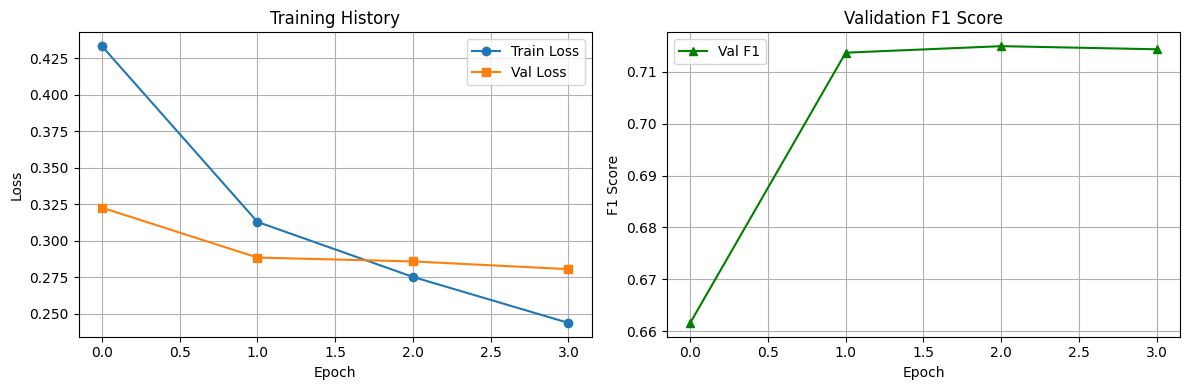

Training loss history: [0.43339880255495644, 0.3128826376407298, 0.27516545897332934, 0.2436450342039435]
Validation loss history: [0.32265756038673254, 0.2884237551435227, 0.2858012363715557, 0.2805011685720474]
Validation F1 history: [0.6616327372370673, 0.7136416844469512, 0.7148945001526664, 0.7142960661302657]


('/kaggle/working/banglabert_multitask/tokenizer_config.json',
 '/kaggle/working/banglabert_multitask/special_tokens_map.json',
 '/kaggle/working/banglabert_multitask/vocab.txt',
 '/kaggle/working/banglabert_multitask/added_tokens.json',
 '/kaggle/working/banglabert_multitask/tokenizer.json')

In [48]:
print(f"\n--- Training with LR={FIXED_LR}, FOCAL_LOSS, and ALPHA={ALPHA_SENTIMENT} for {EPOCHS} epochs ---")

# Clear cache before training
torch.cuda.empty_cache()
gc.collect()

final_model = BanglaBERTMultiTask(
    config,
    use_gradient_checkpointing=False
).to(DEVICE)

# Start training
train_with_loss(
    final_model,
    train_loader,
    val_loader,
    focal_loss_fn,
    lr=FIXED_LR,
    epochs=EPOCHS
)

# Save model
final_model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

In [49]:
# After final_model.save_pretrained(SAVE_DIR)
config.save_pretrained(SAVE_DIR)
print("✅ Custom config saved to:", SAVE_DIR)

✅ Custom config saved to: /kaggle/working/banglabert_multitask


In [50]:
def load_custom_model(model_path, device=DEVICE):
    config = AutoConfig.from_pretrained(SAVE_DIR)
    
    # Add your custom parameters
    config.n_sentiment = 3
    config.n_truth = 2
    config.dropout = 0.1
    
    # Create model
    model = BanglaBERTMultiTask(config)
    
    # Find and load the model file (always load to CPU first)
    model_files = [f for f in os.listdir(model_path) if f.endswith(('.bin', '.safetensors'))]
    if not model_files:
        raise FileNotFoundError(f"No model file found in {model_path}")
    
    model_file = os.path.join(model_path, model_files[0])
    
    if model_file.endswith(".safetensors"):
        from safetensors.torch import load_file
        state_dict = load_file(model_file, device="cpu")
    else:
        state_dict = torch.load(model_file, map_location="cpu")
    
    try:
        model.load_state_dict(state_dict, strict=True)
    except RuntimeError as e:
        print("❌ Model loading failed with strict=True:")
        print(e)
        print("⚠️ Falling back to strict=False — inspect weights!")
        model.load_state_dict(state_dict, strict=False)
    
    # Move to target device
    model.to(device)
    model.eval()
    
    return model

In [51]:
if config.n_sentiment != 3 or config.n_truth != 2:
    print(f"⚠️ Warning: Config expects n_sentiment={config.n_sentiment}, n_truth={config.n_truth}")

In [52]:
model = load_custom_model(SAVE_DIR)

In [53]:
test_metrics = evaluate_with_loss(model, test_loader, focal_loss_fn)
print("\n=== Test Metrics ===")
print(f"Sentiment  : acc={test_metrics['sentiment_acc']:.3f}, macroF1={test_metrics['sentiment_f1']:.3f}")
print(f"Truthfulness: acc={test_metrics['truth_acc']:.3f}, macroF1={test_metrics['truth_f1']:.3f}")

print("\n=== Test Classification Reports ===")
print("\nSentiment Report:")
print(test_metrics["sentiment_report"])
print("\nTruthfulness Report:")
print(test_metrics["truth_report"])


=== Test Metrics ===
Sentiment  : acc=0.751, macroF1=0.707
Truthfulness: acc=0.880, macroF1=0.851

=== Test Classification Reports ===

Sentiment Report:
              precision    recall  f1-score   support

    negative       0.73      0.82      0.77      1546
     neutral       0.69      0.48      0.57       513
    positive       0.79      0.77      0.78      1494

    accuracy                           0.75      3553
   macro avg       0.74      0.69      0.71      3553
weighted avg       0.75      0.75      0.75      3553


Truthfulness Report:
              precision    recall  f1-score   support

        fake       0.76      0.82      0.79       962
        real       0.93      0.90      0.92      2591

    accuracy                           0.88      3553
   macro avg       0.84      0.86      0.85      3553
weighted avg       0.88      0.88      0.88      3553



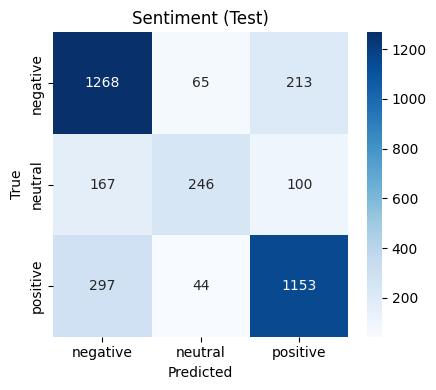

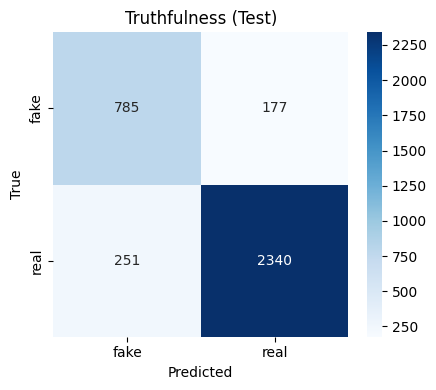

In [54]:
# Confusion matrices
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_cm(test_metrics["y_true_s"], test_metrics["y_pred_s"], [idx2sent[i] for i in range(3)], "Sentiment (Test)")
plot_cm(test_metrics["y_true_t"], test_metrics["y_pred_t"], [idx2truth[i] for i in range(2)], "Truthfulness (Test)")

In [55]:
# Ensure alignment
assert len(df_test) == len(test_metrics["y_true_s"]), "Length mismatch!"

df_err = df_test.reset_index(drop=True)

# Map labels safely
df_err["sent_true"] = pd.Series(test_metrics["y_true_s"]).map(idx2sent).fillna("UNKNOWN")
df_err["sent_pred"] = pd.Series(test_metrics["y_pred_s"]).map(idx2sent).fillna("UNKNOWN")
df_err["truth_true"] = pd.Series(test_metrics["y_true_t"]).map(idx2truth).fillna("UNKNOWN")
df_err["truth_pred"] = pd.Series(test_metrics["y_pred_t"]).map(idx2truth).fillna("UNKNOWN")

# Correctness flags
df_err["sent_correct"] = (df_err["sent_true"] == df_err["sent_pred"]).astype(int)
df_err["truth_correct"] = (df_err["truth_true"] == df_err["truth_pred"]).astype(int)
df_err["both_correct"] = (df_err["sent_correct"] & df_err["truth_correct"]).astype(int)

# Mismatch: raw input vs decoded true label (with NaN safety)
def safe_str_compare(a, b):
    a_clean = a.str.lower().fillna("")
    b_clean = b.str.lower().fillna("")
    return (a_clean != b_clean).astype(int)

df_err["sent_mismatch"] = safe_str_compare(df_err["sentiment"], df_err["sent_true"])
df_err["truth_mismatch"] = safe_str_compare(df_err["truthfulness"], df_err["truth_true"])

In [56]:
print(f"Sentiment mismatch rate: {df_err['sent_mismatch'].mean():.2%}")
print(f"Truthfulness mismatch rate: {df_err['truth_mismatch'].mean():.2%}")

Sentiment mismatch rate: 0.00%
Truthfulness mismatch rate: 0.00%


In [57]:
def cross_check_labels(df_raw, df_err, raw_col, decoded_col, label_map, aliases):
    """
    Vectorized cross-check with detailed mismatch reporting.
    """
    # === Vectorized preprocessing ===
    raw_str = df_raw[raw_col].astype(str).str.strip().str.lower()
    raw_norm = raw_str.map(aliases).fillna(raw_str)  # Apply aliases, fallback to raw
    raw_std = raw_norm.map(label_map)  # Map to standard label (or NaN if unmapped)

    decoded = df_err[decoded_col].astype(str)

    # === Vectorized error classification ===
    is_unmapped = raw_std.isna()
    is_mismatched = ~is_unmapped & (raw_std != decoded)
    
    mismatch_mask = is_unmapped | is_mismatched
    if not mismatch_mask.any():
        print(f"✅ All {raw_col} values align with {decoded_col} after alias normalization.")
        return

    # === Only loop over mismatches (small subset) ===
    mismatches = []
    for i in mismatch_mask[mismatch_mask].index:  # Only mismatched rows
        raw = df_raw.loc[i, raw_col]
        dec = df_err.loc[i, decoded_col]
        if is_unmapped[i]:
            mismatches.append((i, raw, dec, "❌ unmapped"))
        else:
            mismatches.append((i, raw, dec, "⚠ mismatch"))

    print(f"❌ Found {len(mismatches)} mismatches in {raw_col}:")
    for m in mismatches[:10]:  # show first 10
        print(m)

In [58]:
if df_err["sent_mismatch"].any():
    print("\n🔍 Investigating sentiment mismatches...")
    cross_check_labels(df_test, df_err, "sentiment", "sent_true", SENTIMENT_MAP, SENTIMENT_ALIASES)

if df_err["truth_mismatch"].any():
    print("\n🔍 Investigating truthfulness mismatches...")
    cross_check_labels(df_test, df_err, "truthfulness", "truth_true", TRUTH_MAP, TRUTH_ALIASES)

In [59]:
err_path = os.path.join(SAVE_DIR, "error_analysis_test.xlsx")
with pd.ExcelWriter(err_path, engine="openpyxl") as writer:
    df_err.to_excel(writer, index=False, sheet_name="errors")
print(f"✅ Error analysis saved with raw + decoded labels, correctness, and mismatch flags to: {err_path}")

✅ Error analysis saved with raw + decoded labels, correctness, and mismatch flags to: /kaggle/working/banglabert_multitask/error_analysis_test.xlsx


In [60]:
print("\n" + "="*60)
print("📊 ERROR ANALYSIS SUMMARY STATISTICS")
print("="*60)

total_rows = len(df_err)
sent_mismatch_count = df_err['sent_mismatch'].sum()
truth_mismatch_count = df_err['truth_mismatch'].sum()

print(f"Total rows in error analysis: {total_rows:,}")
print(f"Sentiment label mismatches (raw vs decoded): {sent_mismatch_count:,} ({sent_mismatch_count/total_rows:.2%})")
print(f"Truthfulness label mismatches (raw vs decoded): {truth_mismatch_count:,} ({truth_mismatch_count/total_rows:.2%})")

if sent_mismatch_count == 0 and truth_mismatch_count == 0:
    print("\n✅ Perfect! No label mismatches found. Your data pipeline is solid.")
else:
    print(f"\n⚠️  WARNING: Label mismatches detected!")
    if sent_mismatch_count > 0:
        print(f"   - Investigate the 'sent_mismatch' column in the Excel file for sentiment issues.")
    if truth_mismatch_count > 0:
        print(f"   - Investigate the 'truth_mismatch' column in the Excel file for truthfulness issues.")

print("\nCorrectness Summary:")
sent_correct_count = df_err['sent_correct'].sum()
truth_correct_count = df_err['truth_correct'].sum()
both_correct_count = df_err['both_correct'].sum()

print(f"Sentiment predictions correct: {sent_correct_count:,} ({sent_correct_count/total_rows:.2%})")
print(f"Truthfulness predictions correct: {truth_correct_count:,} ({truth_correct_count/total_rows:.2%})")
print(f"Both predictions correct: {both_correct_count:,} ({both_correct_count/total_rows:.2%})")


📊 ERROR ANALYSIS SUMMARY STATISTICS
Total rows in error analysis: 3,553
Sentiment label mismatches (raw vs decoded): 0 (0.00%)
Truthfulness label mismatches (raw vs decoded): 0 (0.00%)

✅ Perfect! No label mismatches found. Your data pipeline is solid.

Correctness Summary:
Sentiment predictions correct: 2,667 (75.06%)
Truthfulness predictions correct: 3,125 (87.95%)
Both predictions correct: 2,479 (69.77%)


In [61]:
# Final config
inference_config = {
    "max_length": MAX_LENGTH,
    "sentiment_map": SENTIMENT_MAP,
    "truth_map": TRUTH_MAP,
    "model_type": "banglabert-multitask",
    "alpha_sentiment": ALPHA_SENTIMENT
}
with open(os.path.join(SAVE_DIR, "inference_config.json"), "w", encoding="utf-8") as f:
    json.dump(inference_config, f, ensure_ascii=False, indent=2)

print("✅ All artifacts saved to:", SAVE_DIR)

✅ All artifacts saved to: /kaggle/working/banglabert_multitask


In [62]:
import gradio as gr
demo_tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)

# ✅ NO text_clean here — it belongs inside the function!

def predict_sentiment_and_truthfulness(text_input):
    if model is None:
        return "❌ Model not loaded!", "❌ Model not loaded!"

    try:
        if not text_input or not text_input.strip():
            return "⚠️ Error: Please enter some Bengali text.", "⚠️ Error: Please enter some Bengali text."

        if len(demo_tokenizer.tokenize(text_input)) > 512:
            return "⚠️ Text too long (max 512 tokens). Truncating...", "..."

        # ✅ CORRECT: Now inside the function — text_input exists
        text_clean = _clean_one(text_input)  # ← This is the only place it should be

        encoded = demo_tokenizer(
            text_clean,
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )

        # Move to device
        input_ids = encoded["input_ids"].to(DEVICE)
        attention_mask = encoded["attention_mask"].to(DEVICE)

        # Predict
        model.eval()
        device_type = "cuda" if DEVICE.type == "cuda" else "cpu"
        with torch.no_grad(), torch.amp.autocast(device_type=device_type):
            logits_s, logits_t = model(input_ids, attention_mask)

        # Get predictions
        pred_sent_idx = torch.argmax(logits_s, dim=1).item()
        pred_truth_idx = torch.argmax(logits_t, dim=1).item()

        pred_sent_label = idx2sent[pred_sent_idx]
        pred_truth_label = idx2truth[pred_truth_idx]

        # Format output
        sentiment_output = f"**Predicted Sentiment:** `{pred_sent_label.upper()}`"
        truth_output = f"**Predicted Truthfulness:** `{pred_truth_label.upper()}`"

        return sentiment_output, truth_output

    except Exception as e:
        error_msg = f"⚠️ Prediction Error: {str(e)}"
        return error_msg, error_msg

In [63]:
# --- Create the Gradio Interface ---
demo = gr.Interface(
    fn=predict_sentiment_and_truthfulness,
    inputs=gr.Textbox(
        lines=5,
        placeholder="Enter Bengali text here (e.g., 'করোনা ভাইরাস নিয়ে সরকারের পদক্ষেপ অত্যন্ত প্রশংসনীয়।')",
        label="📝 Enter Bengali Text"
    ),
    outputs=[
        gr.Markdown(label="📊 Predicted Sentiment"),  # Using Markdown for better formatting
        gr.Markdown(label="🔍 Predicted Truthfulness")
    ],
    title="🇧🇩 Bengali Sentiment and Fake News Detector for COVID-19 Related Content",
    description="""
    **Model:** Fine-tuned BanglaBERT for Multi-Task Learning.
    Enter a piece of Bengali text, click **Get Prediction**, and get instant predictions for:
    1. **Sentiment** (Positive, Negative, Neutral)
    2. **Truthfulness** (Real, Fake)
    """,
    examples=[
        ["করোনা ভাইরাস নিয়ে সরকারের পদক্ষেপ অত্যন্ত প্রশংসনীয়।"],
        ["এই ভ্যাকসিনে মানুষ মারা যাচ্ছে, সরকার লুকাচ্ছে তথ্য।"],
        ["লকডাউনের কারণে অনেকের চাকরি চলে গেছে, কিন্তু এটা প্রয়োজনীয় ছিল।"]
    ],
    theme="soft",
    live=False,
    submit_btn="🚀 Get Prediction",  
    clear_btn="🗑️ Clear"
)

In [64]:
# --- Launch the demo ---
print("🚀 Launching Gradio demo...")
demo.launch(share=True)

🚀 Launching Gradio demo...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://f2919b1064464ccb5c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
